# ===================================
# -- GCP FinOps Project - Jan 2025 --
# ===================================

## ------------------------------------
 Name: GCP_FinOps
 
 Author: Jorge Rodriguez

 Created: Jan-24-2025

 Last Compiled: Jan-30-2024

 Description: 
 
 This program access Big Querry at GCP to access the Billing Table to get all the records for the time perido selectd
## ------------------------------------

In [61]:
#! pip3 install colorama
#! pip3 install --upgrade google-cloud-bigquery
#! pip3 install db-dtypes
#----------- Google CLI <BEGIN> ----------------------
# gcloud auth application-default login
# Credentials saved to file: [/Users/jorge.rodriguez/.config/gcloud/application_default_credentials.json]
# ---------- Google CLI <END> ------------------------

In [62]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# from googleapiclient import discovery
from google.cloud import bigquery
#from google.cloud import billing
from google.api_core import client_info as http_client_info
from google.api_core.exceptions import PermissionDenied
from google.cloud.exceptions import NotFound
import argparse
import sys
#from colorama import Back
#from colorama import Style
import db_dtypes
import pandas as pd
from google.oauth2 import service_account
from google.cloud.bigquery.schema import SchemaField
from google.cloud import bigquery

# Other packages
import pandas as pd
import json 
import ast
import datetime
import time
from datetime import date
from dateutil.relativedelta import relativedelta
import seaborn as sns
import subprocess
from time import time, sleep
import webbrowser
import matplotlib.pyplot as plt


# Connection to Big Query for the billing Project using the CLI Credentials, saved it locally

In [63]:
client = bigquery.Client(project='billing-query-371121')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


# Getting the Datasetes available at the project:

In [64]:
datasets = list(client.list_datasets())  # Make an API request.
project = client.project

if datasets:
    print("Datasets in project {}:".format(project))
    for dataset in datasets:
        print("\t{}".format(dataset.dataset_id))
else:
    print("{} project does not contain any datasets.".format(project))

Datasets in project billing-query-371121:
	all_billing_data


In [65]:
dataset_id = client.project + '.' + dataset.dataset_id
dataset_id

'billing-query-371121.all_billing_data'

# Get the Table we need from the Dataset

In [66]:
# TODO(developer): Set dataset_id to the ID of the dataset that contains
#                  the tables you are listing.
# dataset_id = 'your-project.your_dataset'


tables = client.list_tables(dataset_id)  # Make an API request.

print("Tables contained in '{}':".format(dataset_id))
for table in tables:
    print("{}.{}.{}".format(table.project, table.dataset_id, table.table_id))
    table_id= table.project + '.' + table.dataset_id + '.'+ table.table_id

table_id
table = table.dataset_id + '.'+ table.table_id
table


Tables contained in 'billing-query-371121.all_billing_data':
billing-query-371121.all_billing_data.gcp_billing_export_resource_v1_01C5AB_0209B1_81C892
billing-query-371121.all_billing_data.gcp_billing_export_v1_01C5AB_0209B1_81C892


'all_billing_data.gcp_billing_export_v1_01C5AB_0209B1_81C892'

# Select The Dates for the Report

In [67]:
reportStart = '2025-02-01'
reportEnd = '2025-03-01'
reportYear = '2025'
reportMonth = '02'


# Create the SQL for the date

In [68]:
sql = "SELECT * FROM " + table + " WHERE invoice.month = '" + reportYear+reportMonth + "'"
sql

"SELECT * FROM all_billing_data.gcp_billing_export_v1_01C5AB_0209B1_81C892 WHERE invoice.month = '202502'"

In [69]:
x = client.query(sql)

In [70]:
df = x.to_dataframe()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


# Print the Total Cost GCP

In [13]:
df['cost'].sum()

np.float64(16555.924184)

# Display the Schema 

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480029 entries, 0 to 480028
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype              
---  ------                    --------------   -----              
 0   billing_account_id        480029 non-null  object             
 1   service                   480029 non-null  object             
 2   sku                       480029 non-null  object             
 3   usage_start_time          480029 non-null  datetime64[us, UTC]
 4   usage_end_time            480029 non-null  datetime64[us, UTC]
 5   project                   480029 non-null  object             
 6   labels                    480029 non-null  object             
 7   system_labels             480029 non-null  object             
 8   location                  480029 non-null  object             
 9   tags                      480029 non-null  object             
 10  export_time               480029 non-null  datetime64[us, UTC]
 11  

# Split the Json format to indepedent columns in the dataframe for better consumption and visulization

In [15]:
df['service_id'] = df['service'].apply(lambda x: x['id'])
df['service_description'] = df['service'].apply(lambda x: x['description'])

In [16]:
df['sku_id'] = df['sku'].apply(lambda x: (x)['id'])
df['sku_description'] = df['sku'].apply(lambda x: (x)['description'])

In [17]:
df['project_id'] = df['project'].apply(lambda x: (x)['id'])
df['project_number'] = df['project'].apply(lambda x: (x)['number'])
df['project_name'] = df['project'].apply(lambda x: (x)['name'])
df['project_labels'] = df['project'].apply(lambda x: str((x)['labels']))
df['project_ancestry_numbers'] = df['project'].apply(lambda x: (x)['ancestry_numbers'])
df['project_ancestors'] = df['project'].apply(lambda x: str((x)['ancestors']))

In [18]:
df['usage_amount'] = df['usage'].apply(lambda x: (x)['amount'])
df['usage_unit'] = df['usage'].apply(lambda x: (x)['unit'])
df['usage_amount_in_pricing_units'] = df['usage'].apply(lambda x: (x)['amount_in_pricing_units'])
df['usage_pricing_unit'] = df['usage'].apply(lambda x: (x)['pricing_unit'])

In [19]:
df['invoice_month'] = df['invoice'].apply(lambda x: x['month'][4:])
df['invoice_year'] = df['invoice'].apply(lambda x: x['month'][0:4])
df['invoice_publisher_type'] = df['invoice'].apply(lambda x: x['publisher_type'])

In [20]:
df['location']

0         {'location': None, 'country': None, 'region': ...
1         {'location': None, 'country': None, 'region': ...
2         {'location': None, 'country': None, 'region': ...
3         {'location': None, 'country': None, 'region': ...
4         {'location': None, 'country': None, 'region': ...
                                ...                        
480024    {'location': 'us', 'country': 'US', 'region': ...
480025    {'location': 'us', 'country': 'US', 'region': ...
480026    {'location': 'us', 'country': 'US', 'region': ...
480027    {'location': 'us-east1', 'country': 'US', 'reg...
480028    {'location': 'us', 'country': 'US', 'region': ...
Name: location, Length: 480029, dtype: object

In [602]:
'''
df['location_location'] = None
df['location_country'] = None
df['location_region'] = None
df['location_zone'] = None
'''


In [21]:
df['location_location'] = df['location'].apply(lambda x: (x)['location'])
df['location_country'] = df['location'].apply(lambda x: (x)['country'])
df['location_region'] = df['location'].apply(lambda x: (x)['region'])
df['location_zone'] = df['location'].apply(lambda x: (x)['zone'])

# Get record 0 as sample to validate all the fields are OK

In [22]:
df.iloc[200,:]

billing_account_id                                            01C5AB-0209B1-81C892
service                          {'id': '5490-F7B7-8DF6', 'description': 'Cloud...
sku                              {'id': '143F-A1B0-E0BE', 'description': 'Log S...
usage_start_time                                         2025-02-07 10:00:00+00:00
usage_end_time                                           2025-02-07 11:00:00+00:00
project                          {'id': 'adminql-93f0e', 'number': '53702907559...
labels                             [{'key': 'goog-resource-type', 'value': 'api'}]
system_labels                                                                   []
location                         {'location': 'us', 'country': 'US', 'region': ...
tags                                                                            []
export_time                                       2025-02-07 13:26:45.946685+00:00
cost                                                                           0.0
curr

In [25]:
df.iloc[200,:]['labels'][0]

{'key': 'goog-resource-type', 'value': 'api'}

In [26]:
#l = df[df['labels'] != "[]"]

In [27]:
#l

In [28]:
df['invoice_year'].unique()

array(['2025'], dtype=object)

In [29]:
df['invoice_month'].unique()

array(['02'], dtype=object)

In [30]:
df['cost'].sum()

np.float64(16555.924184)

# Get the name of the file to be saved it wiht the correct month and year

In [31]:
month = "GCP_Monthly_Cost_For_"+reportMonth+"_" + reportYear
month

'GCP_Monthly_Cost_For_02_2025'

# Save the Data as CSV

In [32]:
df.to_csv(month+".csv")

# Filter the Data for cost greather than $0.001

In [33]:
df1 = df[df['cost'] > 0.001]

In [34]:
df1['cost'].sum()

np.float64(16546.925933000002)

In [35]:
total_per_account_df = df1.groupby(['invoice_year','invoice_month','project_id','project_name']).agg({'cost':'sum'})
total_per_account_df['Total in Thousands'] = total_per_account_df['cost']/1000
total_per_account_df

cost  \
invoice_year invoice_month project_id                     project_name                               
2025         02            a3-nonprod-482353              a3-nonprod                      3.977906   
                           amperwave-adtech               amperwave-adtech                1.669150   
                           arched-hybrid-112221           BetQL Main                   2278.156181   
                           aud-apigee-x-nonprod           aud-apigee-x-nonprod           41.316651   
                           aud-apigee-x-prod              aud-apigee-x-prod             287.162170   
                           aud-dc-code-repository         aud-dc-code-repository        705.602427   
                           aud-dc-fortinet-prod           aud-dc-fortinet-prod            0.600481   
                           audacy-data-sci-gen-ai-prod    audacy-data-sci-gen-ai-prod     7.085904   
                           audacy-data-science-gen-ai-dev audacy-data-sci-gen-ai-dev    814.638135   
                           audacy-dc-backupdr             audacy-dc-backupdr           1359.911565   
                           audacy-dc-dev                  audacy-dc-dev                 273.478465   
                           billing-query-371121           billing-query                   0.048405   
                           iceberg-prod                   wo-wos-iceberg-prod             1.297770   
                           iceberg-qa                     wo-wos-iceberg-qa              24.656342   
                           iceberg-staging                wo-wos-iceberg-staging          5.203390   
                           noc-task-assignment-zendesk    NOC-Task Assignment Zendesk     4.142080   
                           podcorn-376312                 podcorn                         1.180000   
                           prj-common-net-nonprod-2d37    prj-common-net-nonprod          0.805831   
                           prj-common-netsec-core-b233    prj-common-netsec-core         84.560104   
                           prj-fin-hd-nonprod-ce11        prj-fin-hd-nonprod             56.999004   
                           prj-fin-hd-prod-4e7c           prj-fin-hd-prod                47.481105   
                           prj-genai-nonprod-54b6         prj-genai-nonprod             112.157899   
                           prj-initiatives-nonprod-1703   prj-initiatives-nonprod        86.344005   
                           prj-org-seed-435208            prj-common-mgt-admin            0.020374   
                           prj-revops-prod-1db5           prj-revops-prod                 1.406835   
                           rotoql-static                  RotoQL Static                   0.220779   
                           secops-opintel                 secops-opintel                  0.528139   
                           secops-terraform-dev           secops-terraform-dev           75.637607   
                           shared-vpc-nonprod-234563      shared-vpc-nonprod              0.771717   
                           sra-xdr-sentinel-330418        SRA-XDR-Sentinel               60.532347   
                           uap-ga360-data                 UAP GA360 Data                 75.105412   
                           wo-analytics-hub-poc           wo-analytics-hub-poc            0.089464   
                           wo-ondemand-qa                 wo-ondemand-qa                 15.585707   
                           wo-wos-reporting-291617        wo-wos-reporting-dev          284.311599   
                           wo-wos-reporting-prod          wo-wos-reporting-prod        8435.458567   

                                                                                       Total in Thousands  
invoice_year invoice_month project_id                     project_name                                     
2025         02            a3-nonprod-482353              a3-nonprod                             0.0039

In [36]:
total_per_account_df['cost'].sum()

np.float64(15148.143517)

In [37]:
df['cost'].sum()

np.float64(16555.924184)

/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2756079435.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')


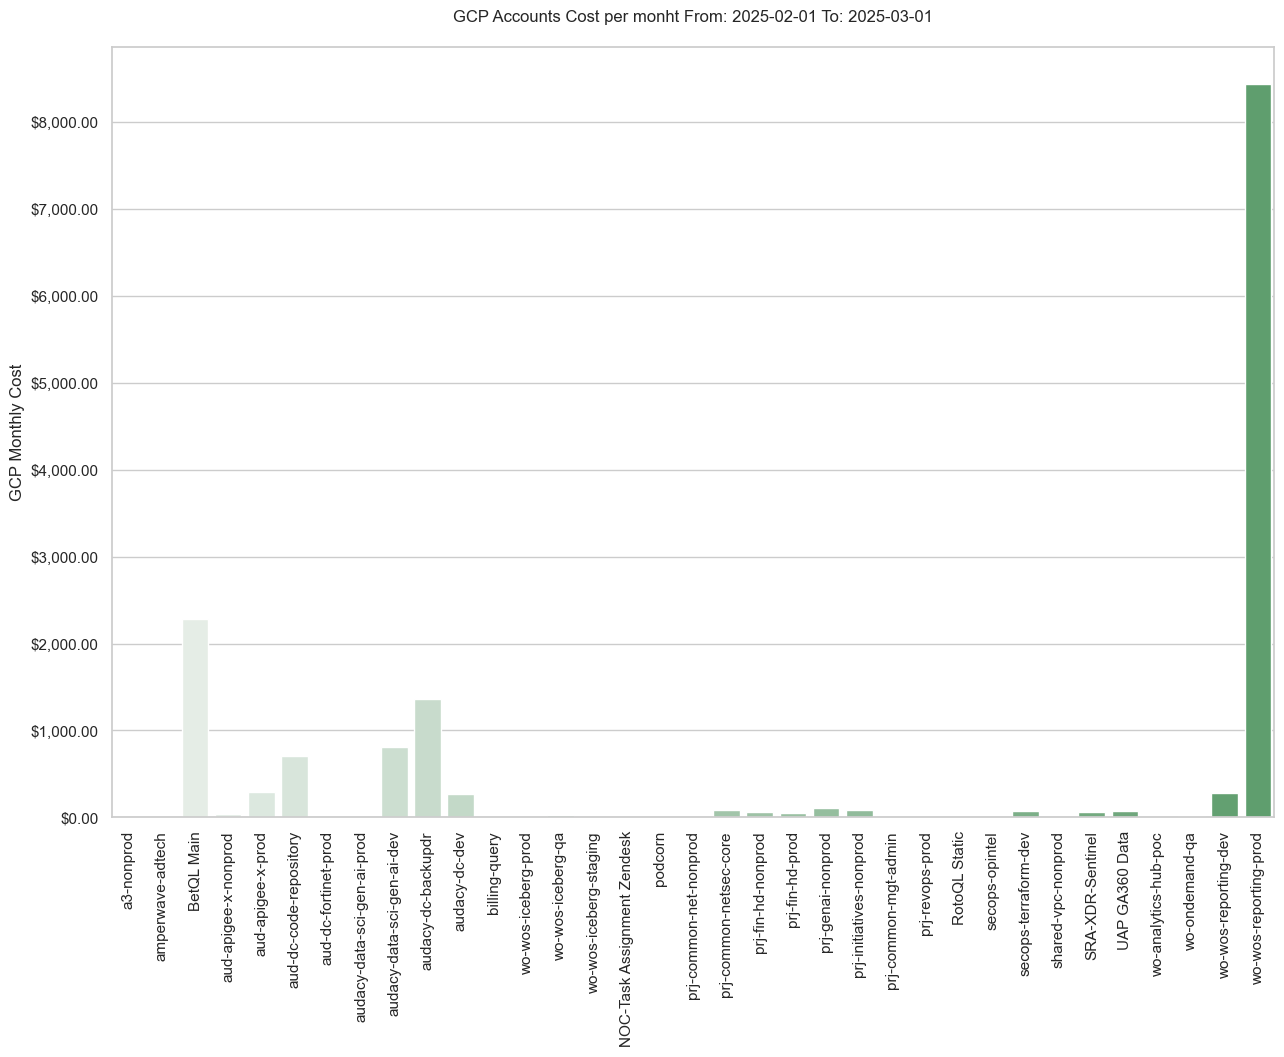

In [38]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 10))

monthly_cost = 1
#sns.set_color_codes("pastel")
sns.barplot(y="cost", x="project_name", data=total_per_account_df,
            palette='light:g', hue='project_name', legend=False)


# Add a legend and informative axis label
#ax.legend(ncol=2, loc="lower right", frameon=True)
#ylim=(0, 35000),
ax.set( xlabel="",
       ylabel="GCP Monthly Cost")
ax.set_title("GCP Accounts Cost per monht From: " + reportStart + " To: " + reportEnd + '\n')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.2f}".format(int(x))))
#sns.despine(left=True, bottom=True)

In [39]:
total_per_service_df = df1.groupby(['invoice_year','service_description']).agg(Total=('cost','sum'))

In [40]:
t = total_per_service_df['Total'].sum()
t

np.float64(16546.925933000002)

In [41]:
services_df = total_per_service_df[total_per_service_df['Total'] > 100]

/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/3561150770.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')


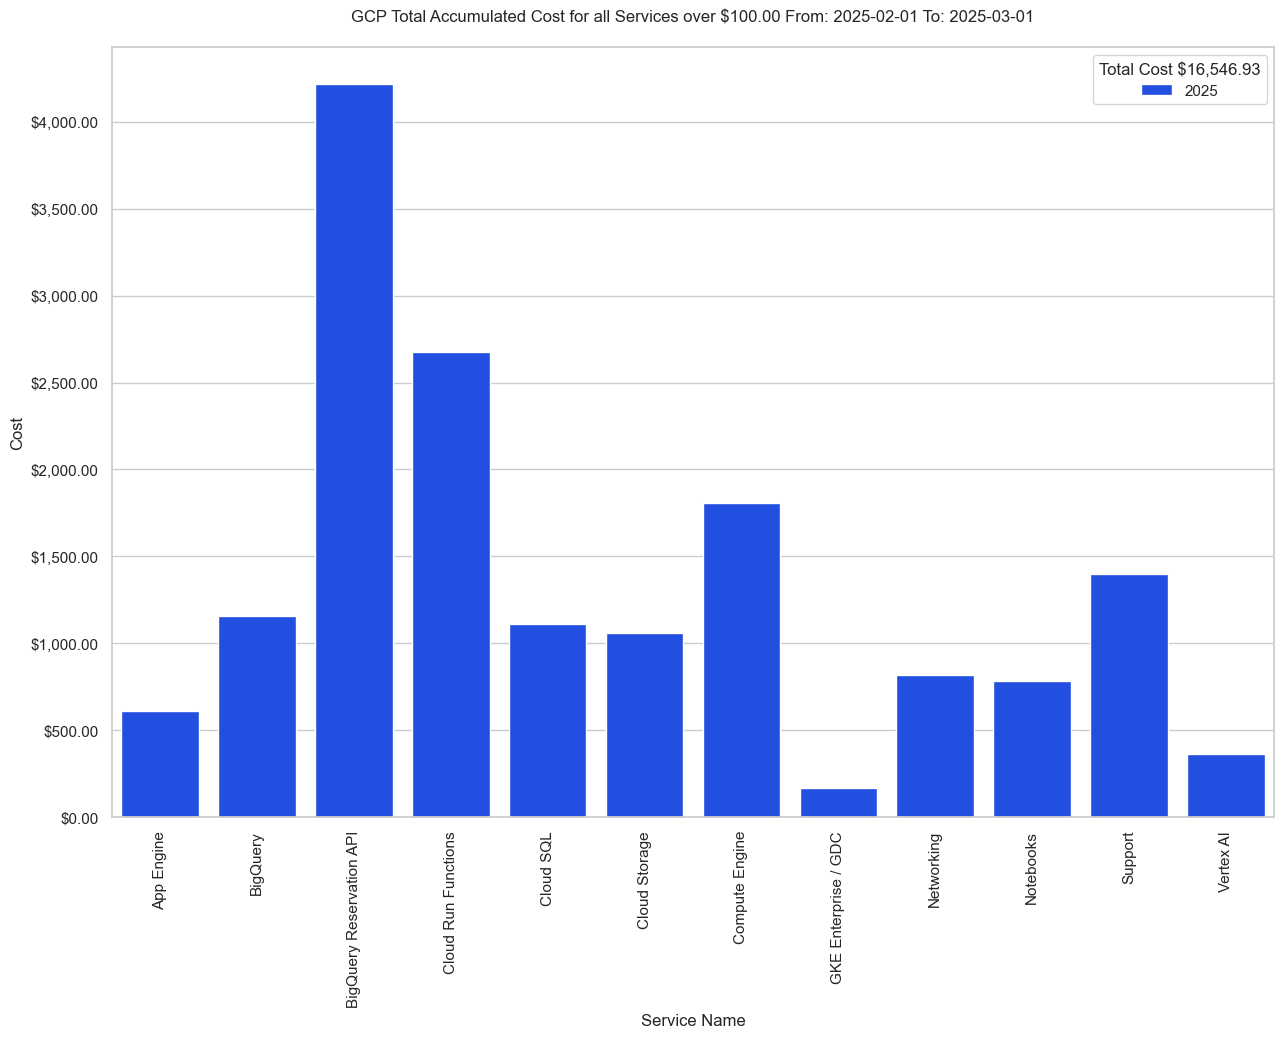

In [42]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x="service_description", y="Total", data=services_df,
            hue='invoice_year', legend=True, color='green',palette='bright')


# Add a legend and informative axis label
#ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set_xlabel("Service Name")
ax.set_ylabel("Cost")
ax.legend(title="Total Cost $"+str("{:,.2f}".format(t)))
#ax.set_title("GCP Accounts Cost per monht From: " + reportStart + " To: " + reportEnd + '\n')
ax.set_title("GCP Total Accumulated Cost for all Services over $100.00 From: " + reportStart + " To: " + reportEnd + "\n")
#ax.set_title("AWS Total Cost for Jun, 2024 by Services over $100,000 \n")
#plt.xticks(rotation=90) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
#ax.set_xticklabels(labels=services_df['Service'],rotation=45)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.2f}".format(int(x))))
plt.savefig("GCP Yearly Cost by Service ID")

# Reading all CSV Files:

In [43]:
import glob

# Get a list of all CSV files in the directory
csv_files = glob.glob('GCP_Monthly_Cost_For_*.csv')

# Create an empty list to store the DataFrames
dfs = [] 

# Loop over each CSV file and read it into a DataFrame
for file in csv_files:
    print("reading File: " + file)
    df = pd.read_csv(file) 
    dfs.append(df) 

# Concatenate all the DataFrames into one
combined_df = pd.concat(dfs, axis=0, ignore_index=True) 
'''
month_name = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
month_number = [1,2,3,4,5,6,7,8,9,10,11,12]
kafka_new ='Apache Kafka® & Apache Flink® on Confluent Cloud™ - Annual Commits'
kafka_old ='Apache Kafka® on Confluent Cloud™ - Annual Commits'
combined_df['Month No'] = combined_df['Month'].replace(month_name,month_number)
combined_df['Service'] = combined_df['Service'].replace('Datadog Pro','Datadog')
combined_df['Service'] = combined_df['Service'].replace(kafka_old,kafka_new)
'''

# Print the combined DataFrame
combined_df.sample(30)

reading File: GCP_Monthly_Cost_For_06_2024.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_07_2024.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_11_2023.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_10_2023.csv
reading File: GCP_Monthly_Cost_For_11_2024.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (22,39,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_10_2024.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_06_2023.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_07_2023.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_01_2023.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_01_2024.csv
reading File: GCP_Monthly_Cost_For_01_2025.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_12_2024.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_05_2023.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_04_2023.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_05_2024.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_04_2024.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_12_2023.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_08_2024.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_09_2024.csv
reading File: GCP_Monthly_Cost_For_02_2024.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_03_2024.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_02_2025.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_08_2023.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (21,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_09_2023.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_02_2023.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


reading File: GCP_Monthly_Cost_For_03_2023.csv


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2974810727.py:12: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


,Unnamed: 0,billing_account_id,service,sku,usage_start_time,usage_end_time,project,labels,system_labels,location,...,usage_unit,usage_amount_in_pricing_units,usage_pricing_unit,invoice_month,invoice_year,invoice_publisher_type,location_location,location_country,location_region,location_zone
15235204,180987,01C5AB-0209B1-81C892,"{'id': 'A1E8-BE35-7EBC', 'description': 'Cloud...","{'id': '3EAB-48F3-A0D5', 'description': 'Subsc...",2024-05-25 00:00:00+00:00,2024-05-25 01:00:00+00:00,"{'id': 'sra-xdr-sentinel-330418', 'number': '8...",[],[],"{'location': 'europe-central2', 'country': 'PL...",...,byte-seconds,1.000000e-09,gibibyte month,5,2024,NaN,europe-central2,PL,europe-central2,NaN
21937560,348536,01C5AB-0209B1-81C892,"{'id': 'E505-1604-58F8', 'description': 'Netwo...","{'id': '6F2D-F158-5D10', 'description': 'Netwo...",2025-02-01 23:00:00+00:00,2025-02-02 00:00:00+00:00,"{'id': 'audacy-dc-backupdr', 'number': '372247...",[],[],"{'location': 'us-central1', 'country': 'US', '...",...,seconds,3.984972e+01,hour,2,2025,GOOGLE,us-central1,US,us-central1,NaN
13511276,319215,01C5AB-0209B1-81C892,"{'id': '5AF5-2C11-D467', 'description': 'Cloud...","{'id': '38BC-F861-2EB5', 'description': 'Redis...",2023-05-29 23:00:00+00:00,2023-05-30 00:00:00+00:00,"{'id': 'arched-hybrid-112221', 'number': '9741...",[],[],"{'location': 'us-central1', 'country': 'US', '...",...,byte-seconds,7.708333e-01,gibibyte hour,5,2023,NaN,us-central1,US,us-central1,NaN
15624313,570096,01C5AB-0209B1-81C892,"{'id': '5490-F7B7-8DF6', 'description': 'Cloud...","{'id': '143F-A1B0-E0BE', 'description': 'Log S...",2024-05-03 07:00:00+00:00,2024-05-03 08:00:00+00:00,"{'id': 'wo-wos-reporting-prod', 'number': '399...","[{'key': 'goog-resource-type', 'value': 'cloud...",[],"{'location': 'us', 'country': 'US', 'region': ...",...,bytes,1.812472e-02,gibibyte,5,2024,NaN,us,US,NaN,NaN
1944465,1035319,01C5AB-0209B1-81C892,"{'id': '6F81-5844-456A', 'description': 'Compu...","{'id': '7EDC-324D-8320', 'description': 'Netwo...",2024-07-08 13:00:00+00:00,2024-07-08 14:00:00+00:00,"{'id': 'arched-hybrid-112221', 'number': '9741...",[],[],"{'location': 'us-central1', 'country': 'US', '...",...,bytes,2.407200e-05,gibibyte,7,2024,NaN,us-central1,US,us-central1,NaN
10338114,1423534,01C5AB-0209B1-81C892,"{'id': 'E505-1604-58F8', 'description': 'Netwo...","{'id': '50F4-D7E5-3682', 'description': 'Netwo...",2025-01-04 15:00:00+00:00,2025-01-04 16:00:00+00:00,"{'id': 'secops-terraform-dev', 'number': '2980...",[],[],"{'location': 'us-central1', 'country': 'US', '...",...,seconds,2.016132e-03,month,1,2025,GOOGLE,us-central1,US,us-central1,NaN
2404733,446889,01C5AB-0209B1-81C892,"{'id': '6F81-5844-456A', 'description': 'Compu...","{'id': '6B8F-E63D-832B', 'description': 'Netwo...",2023-11-27 22:00:00+00:00,2023-11-27 23:00:00+00:00,"{'id': 'arched-hybrid-112221', 'number': '9741...",[],[],"{'location': 'us-central1', 'country': 'US', '...",...,bytes,8.445950e-04,gibibyte,11,2023,NaN,us-central1,US,us-central1,NaN
6706154,166796,01C5AB-0209B1-81C892,"{'id': 'A1E8-BE35-7EBC', 'description': 'Cloud...","{'id': 'A8B0-3AAC-6BBD', 'description': 'Inter...",2023-07-30 10:00:00+00:00,2023-07-30 11:00:00+00:00,"{'id': 'sra-xdr-sentinel-330418', 'number': '8...",[],[],"{'location': 'us-east4', 'country': 'US', 'reg...",...,bytes,4.854299e-03,gibibyte,7,2023,NaN,us-east4,US,us-east4,NaN
20993010,219343,01C5AB-0209B1-81C892,"{'id': 'E505-1604-58F8', 'description': 'Netwo...","{'id': '6F2D-F158-5D10', 'description': 'Netwo...",2024-03-31 09:00:00+00:00,2024-03-31 10:00:00+00:00,"{'id': 'audacy-dc-backupdr', 'number': '372247...",[],[],"{'location': 'us-central1', 'country': 'US', '...",...,seconds,9.100000e+01,hour,3,2024,NaN,us-central1,US,us-central1,NaN
23875710,470206,01C5AB-0209B1-81C892,"{'id': '6F81-5844-456A', 'description': 'Compu...","{'id': '5E0D-5F20-E67E', 'description': 'Netwo...",2023-02-24 22:00:00+00:00,2023-02-24 23:00:00+00:00,"{'id': 'arched-hybrid-112221', 'number': '9741...",[],[],"{'l

In [44]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24585732 entries, 0 to 24585731
Data columns (total 44 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Unnamed: 0                     int64  
 1   billing_account_id             object 
 2   service                        object 
 3   sku                            object 
 4   usage_start_time               object 
 5   usage_end_time                 object 
 6   project                        object 
 7   labels                         object 
 8   system_labels                  object 
 9   location                       object 
 10  tags                           object 
 11  export_time                    object 
 12  cost                           float64
 13  currency                       object 
 14  currency_conversion_rate       float64
 15  usage                          object 
 16  credits                        object 
 17  invoice                        object 
 18  

In [45]:
#otal_per_month_df = combined_df.groupby(['Year','Month','Month No']).agg({'Cost':'sum'}).sort_values(by='Month')
total_per_month_df = combined_df.groupby(['invoice_year','invoice_month']).agg(Total_cost_per_Month=('cost','sum')).sort_values(by='invoice_month')
total_per_month_df['Cost_in_Millions'] = total_per_month_df['Total_cost_per_Month']/1000
total_per_month_df 

Total_cost_per_Month  Cost_in_Millions
invoice_year invoice_month                                        
2023         1                      60981.840065         60.981840
2024         1                      62115.759316         62.115759
2025         1                      90466.182902         90.466183
2024         2                      72661.033397         72.661033
2025         2                      16555.924184         16.555924
2023         2                      56849.031151         56.849031
             3                      62552.711900         62.552712
2024         3                      73420.028215         73.420028
             4                      73603.634978         73.603635
2023         4                      57195.365732         57.195366
             5                      41423.185156         41.423185
2024         5                      77595.428145         77.595428
             6                      72804.470904         72.804471
2023         6                      38963.832316         38.963832
             7                      53721.722347         53.721722
2024         7                      81037.174544         81.037175
2023         8                      64986.190646         64.986191
2024         8                      71951.717317         71.951717
             9                      89353.334996         89.353335
2023         9                      62599.293673         62.599294
             10                    461994.640685        461.994641
2024         10                    524657.611693        524.657612
             11                     88402.945195         88.402945
2023         11                     49851.635336         49.851635
             12                     53290.551769         53.290552
2024         12                     83374.807334         83.374807

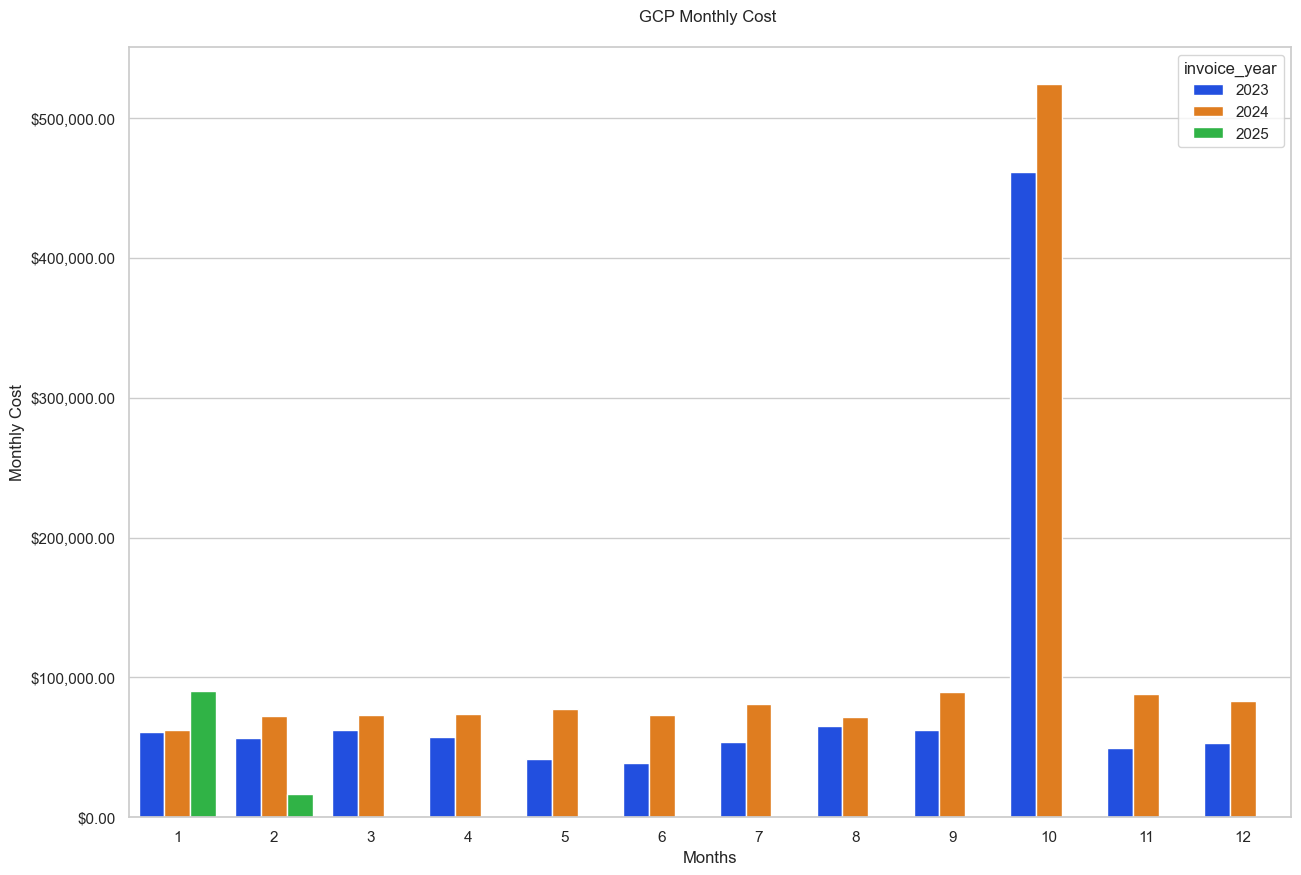

In [46]:
# Initialize the matplotlib figure
#sns.color_palette("viridis", as_cmap=True)
sns.color_palette("bright")
fig, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x="invoice_month", y="Total_cost_per_Month", data=total_per_month_df,
            hue='invoice_year', legend=True, color='green',palette='bright')


# Add a legend and informative axis label
#ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set_xlabel("Months")
ax.set_ylabel("Monthly Cost")
ax.set_title("GCP Monthly Cost \n")
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.2f}".format(int(x))))
plt.savefig("AWS Monthly Cost")


#sns.despine(left=True, bottom=True)

In [435]:
# df = pd.read_csv('GCP_Monthly_Cost_For_10_2024.csv') 

In [436]:
# df['cost'].max()

In [437]:
# df[df['cost'] == 408274.31]['service_description']

In [438]:
# df.iloc[838044,:]

In [54]:
#df_c = combined_df.copy()

In [47]:
total_per_project_df = combined_df.groupby(['invoice_year','project_id','project_name']).agg(Total=('cost','sum'))

In [37]:
#total_per_project_df = df.groupby(['invoice_year','project_name']).agg(Total=('cost','sum'))

In [48]:
total_per_service_df = combined_df.groupby(['invoice_year','service_description']).agg(Total=('cost','sum'))

In [49]:
services_df = total_per_service_df[total_per_service_df['Total'] > 100]

In [50]:
projects_df = total_per_project_df[total_per_project_df['Total'] > 100]

In [51]:
projects_df

Total
invoice_year project_id              project_name                          
2023         arched-hybrid-112221    BetQL Main               136284.454650
             aud-dc-fortinet-prod    aud-dc-fortinet-prod        646.960936
             audacy-backupdr         entit-backupdr-prd-0122   87046.791746
             audacy-dc-backupdr      audacy-dc-backupdr        55350.435600
             biqquery-poc-0123       biqquery-poc-0123         21785.498137
...                                                                     ...
2025         secops-terraform-dev    secops-terraform-dev        442.240493
             sra-xdr-sentinel-330418 SRA-XDR-Sentinel            342.783011
             uap-ga360-data          UAP GA360 Data              416.414936
             wo-wos-reporting-291617 wo-wos-reporting-dev       1560.651146
             wo-wos-reporting-prod   wo-wos-reporting-prod     46044.958564

[61 rows x 1 columns]

In [52]:
services_df

Total
invoice_year service_description                    
2023         Anthos / GDC-V              2146.928323
             App Engine                 36362.840409
             BigQuery                  298211.431812
             BigQuery Reservation API  221950.034917
             BigQuery Storage API         816.060396
...                                              ...
2025         Invoice                     2074.834026
             Networking                  4763.922605
             Notebooks                   4645.178259
             Support                     6787.007664
             Vertex AI                   1016.096723

[69 rows x 1 columns]

/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/928247486.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')


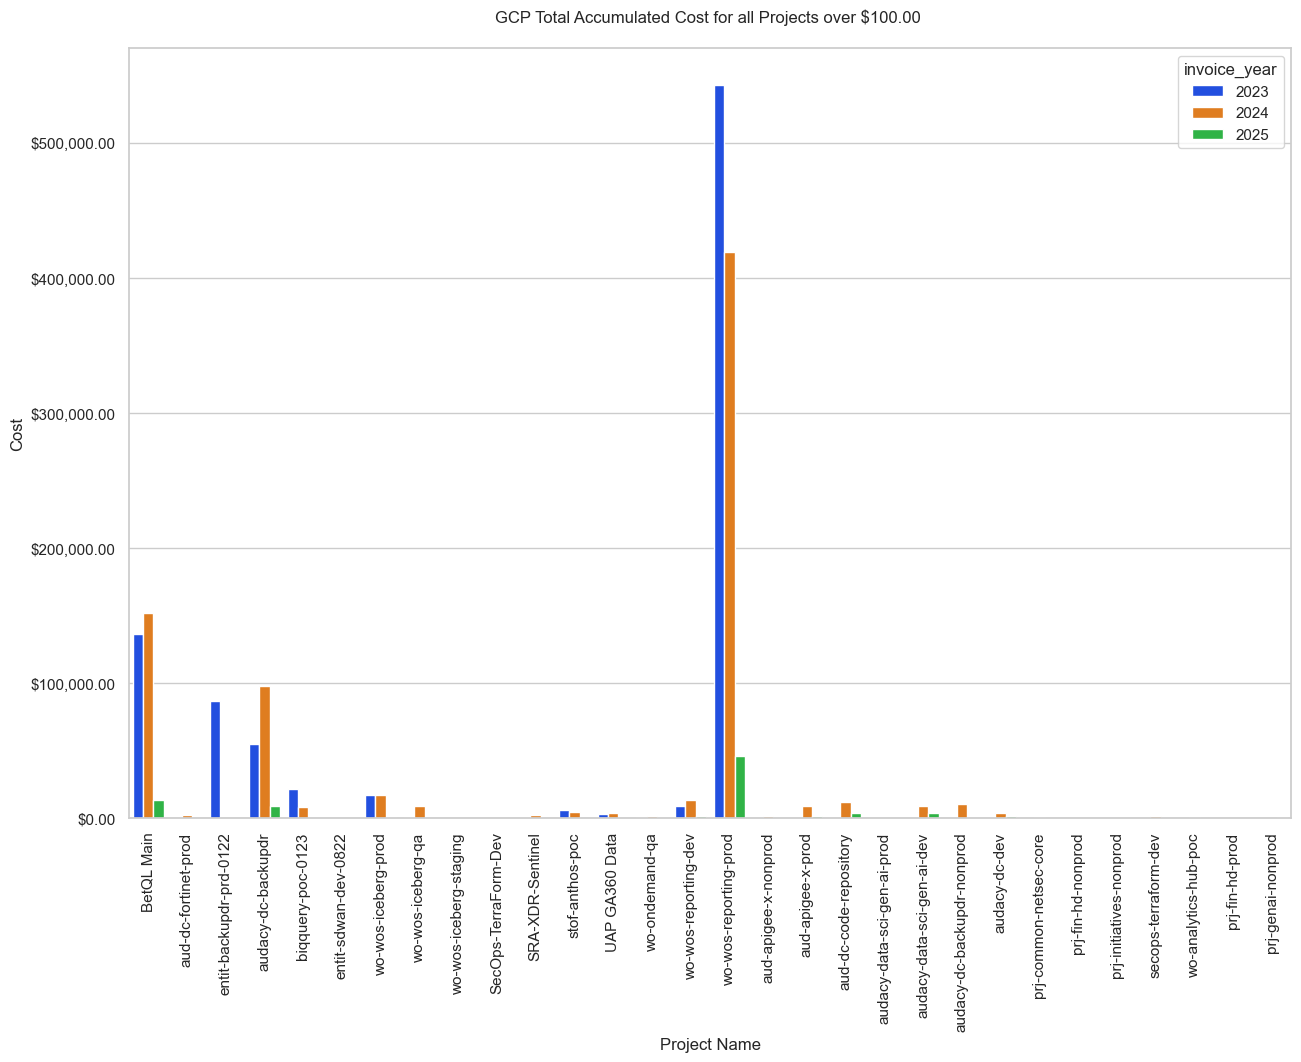

In [53]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x="project_name", y="Total", data=projects_df,
            hue='invoice_year', legend=True, color='green',palette='bright')


# Add a legend and informative axis label
#ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set_xlabel("Project Name")
ax.set_ylabel("Cost")
ax.set_title("GCP Total Accumulated Cost for all Projects over $100.00 \n")
#ax.set_title("AWS Total Cost for Jun, 2024 by Services over $100,000 \n")
#plt.xticks(rotation=90) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
#ax.set_xticklabels(labels=services_df['Service'],rotation=45)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.2f}".format(int(x))))
plt.savefig("GCP Yearly Cost by Project Name")

/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2937903153.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')


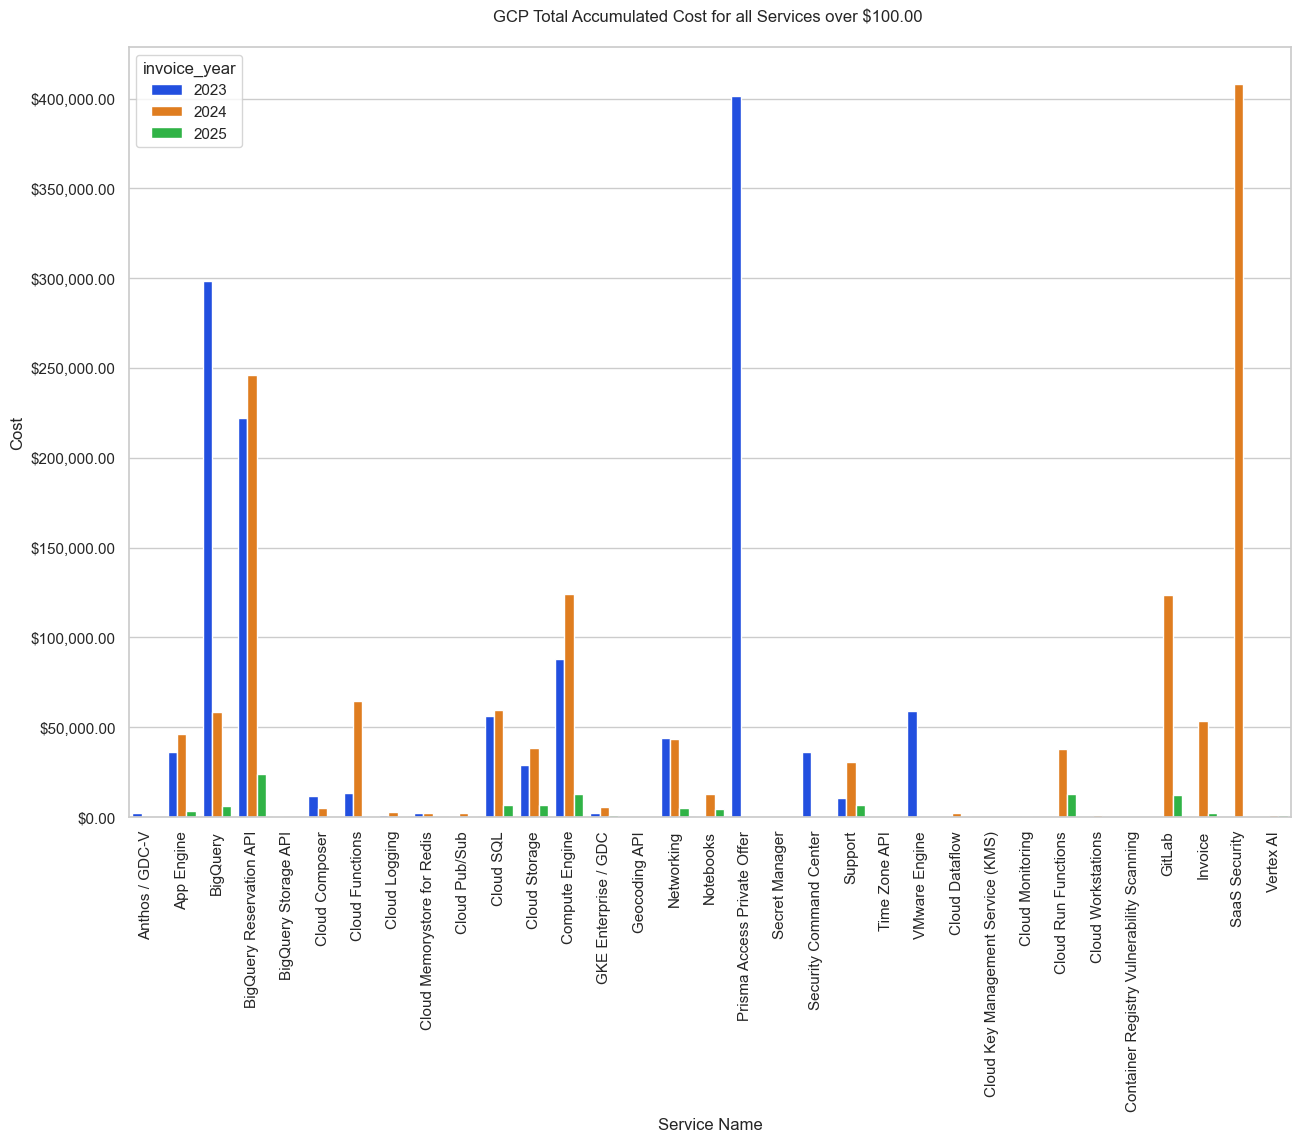

In [54]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x="service_description", y="Total", data=services_df,
            hue='invoice_year', legend=True, color='green',palette='bright')


# Add a legend and informative axis label
#ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set_xlabel("Service Name")
ax.set_ylabel("Cost")
ax.set_title("GCP Total Accumulated Cost for all Services over $100.00 \n")
#ax.set_title("AWS Total Cost for Jun, 2024 by Services over $100,000 \n")
#plt.xticks(rotation=90) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
#ax.set_xticklabels(labels=services_df['Service'],rotation=45)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.2f}".format(int(x))))
plt.savefig("GCP Yearly Cost by Service ID")

In [55]:

#df[df[['project_name'] == 'wo-wos-reporting-prod'  ['invoice_year'] == 2025]]

w = combined_df.query('project_name == "wo-wos-reporting-prod" and invoice_year <= 2025')
w['service_description'].unique()



array(['Cloud Pub/Sub', 'Compute Engine', 'Cloud Storage', 'Cloud SQL',
       'Cloud Logging', 'BigQuery Storage API', 'Vertex AI',
       'Deep Learning VM', 'Cloud Functions', 'Notebooks',
       'BigQuery Reservation API', 'BigQuery', 'Support',
       'Artifact Registry', 'Networking', 'Cloud Scheduler', 'Invoice',
       'Cloud Build', 'Cloud Run Functions', 'Cloud Composer',
       'Stackdriver Monitoring', 'Cloud Monitoring', 'Dataplex',
       'Secret Manager'], dtype=object)

In [56]:
total_per_service_df = w.groupby(['invoice_year','service_description']).agg(Total=('cost','sum'))

In [57]:
services_df = total_per_service_df[total_per_service_df['Total'] > 100]

In [58]:
total_per_service_df

Total
invoice_year service_description                    
2023         Artifact Registry              1.204415
             BigQuery                  281382.337047
             BigQuery Reservation API  221950.034917
             BigQuery Storage API           0.000000
             Cloud Build                    0.000000
             Cloud Composer              2647.991224
             Cloud Functions            13373.371003
             Cloud Logging                 98.349596
             Cloud Monitoring               0.000000
             Cloud Pub/Sub                  0.000015
             Cloud SQL                   8796.541757
             Cloud Scheduler                1.315605
             Cloud Storage               5313.406042
             Compute Engine              3266.555373
             Deep Learning VM               0.000000
             Invoice                      886.141376
             Networking                    92.851496
             Notebooks                    641.571384
             Stackdriver Monitoring         0.000000
             Support                     4355.225076
             Vertex AI                      5.026404
2024         Artifact Registry              1.562854
             BigQuery                   34230.221391
             BigQuery Reservation API  246054.293406
             BigQuery Storage API           0.000000
             Cloud Build                    0.000000
             Cloud Functions            64215.955266
             Cloud Logging                123.114059
             Cloud Pub/Sub                  0.333774
             Cloud Run Functions        37931.957526
             Cloud SQL                   9011.517361
             Cloud Scheduler                2.145133
             Cloud Storage               8659.716950
             Compute Engine               507.612893
             Dataplex                      -0.000062
             Deep Learning VM               0.000000
             Invoice                     1149.822152
             Networking                    42.286856
             Notebooks                   5324.437789
             Support                    11356.128447
             Vertex AI                    776.638580
2025         Artifact Registry              0.287498
             BigQuery                    4693.052624
             BigQuery Reservation API   23784.351386
             BigQuery Storage API           0.000000
             Cloud Build                    0.000000
             Cloud Logging                 16.449058
             Cloud Pub/Sub                  0.007199
             Cloud Run Functions        12864.294105
             Cloud SQL                    940.500858
             Cloud Scheduler                0.190944
             Cloud Storage               1841.097285
             Compute Engine                51.518748
             Deep Learning VM               0.000000
             Invoice                      167.429267
             Networking                     4.941511
             Notebooks                   1584.912056
             Secret Manager                 0.003610
             Vertex AI                     95.922415

/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_11638/2595854041.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')


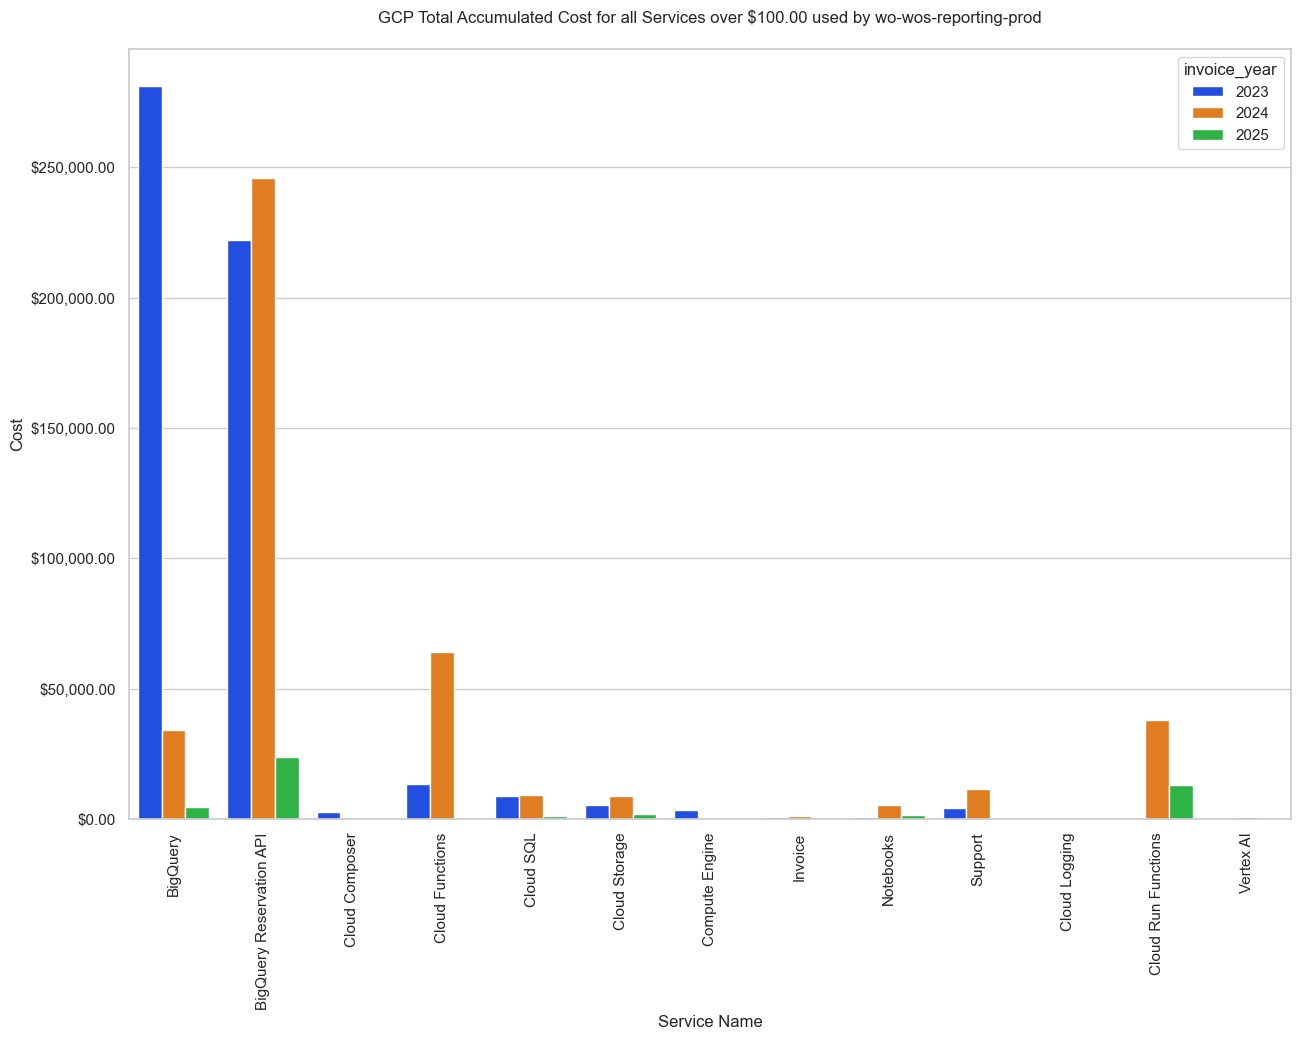

In [59]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x="service_description", y="Total", data=services_df,
            hue='invoice_year', legend=True, color='green',palette='bright')


# Add a legend and informative axis label
#ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set_xlabel("Service Name")
ax.set_ylabel("Cost")
ax.set_title("GCP Total Accumulated Cost for all Services over $100.00 used by wo-wos-reporting-prod\n")
#ax.set_title("AWS Total Cost for Jun, 2024 by Services over $100,000 \n")
#plt.xticks(rotation=90) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
#ax.set_xticklabels(labels=services_df['Service'],rotation=45)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.2f}".format(int(x))))
plt.savefig("GCP Yearly Cost by Service ID")

# This section is a manual way to get rows without SQL < BEGIN >

In [30]:

tbl = client.get_table(table_id)
schema = tbl.schema

In [31]:
len(schema)

22

In [32]:
column_names = []
for i in range(0,22):
    print("-"*30)
    print (tbl.schema[i].name)
    print (tbl.schema[i].field_type)
    print (tbl.schema[i].mode)
    print (tbl.schema[i].description)
    column_names.append(tbl.schema[i].name)

------------------------------
billing_account_id
STRING
NULLABLE

------------------------------
service
RECORD
NULLABLE

------------------------------
sku
RECORD
NULLABLE

------------------------------
usage_start_time
TIMESTAMP
NULLABLE

------------------------------
usage_end_time
TIMESTAMP
NULLABLE

------------------------------
project
RECORD
NULLABLE

------------------------------
labels
RECORD
REPEATED

------------------------------
system_labels
RECORD
REPEATED

------------------------------
location
RECORD
NULLABLE

------------------------------
tags
RECORD
REPEATED

------------------------------
export_time
TIMESTAMP
NULLABLE

------------------------------
cost
FLOAT
NULLABLE

------------------------------
currency
STRING
NULLABLE

------------------------------
currency_conversion_rate
FLOAT
NULLABLE

------------------------------
usage
RECORD
NULLABLE

------------------------------
credits
RECORD
REPEATED

------------------------------
invoice
RECORD
NULLABLE

In [33]:
column_names

['billing_account_id',
 'service',
 'sku',
 'usage_start_time',
 'usage_end_time',
 'project',
 'labels',
 'system_labels',
 'location',
 'tags',
 'export_time',
 'cost',
 'currency',
 'currency_conversion_rate',
 'usage',
 'credits',
 'invoice',
 'cost_type',
 'adjustment_info',
 'cost_at_list',
 'transaction_type',
 'seller_name']

In [34]:
schema_df = pd.DataFrame(columns=column_names)

print(schema_df)

Empty DataFrame
Columns: [billing_account_id, service, sku, usage_start_time, usage_end_time, project, labels, system_labels, location, tags, export_time, cost, currency, currency_conversion_rate, usage, credits, invoice, cost_type, adjustment_info, cost_at_list, transaction_type, seller_name]
Index: []

[0 rows x 22 columns]


In [35]:
schema_df.columns 

Index(['billing_account_id', 'service', 'sku', 'usage_start_time',
       'usage_end_time', 'project', 'labels', 'system_labels', 'location',
       'tags', 'export_time', 'cost', 'currency', 'currency_conversion_rate',
       'usage', 'credits', 'invoice', 'cost_type', 'adjustment_info',
       'cost_at_list', 'transaction_type', 'seller_name'],
      dtype='object')

In [36]:
schema_df

,billing_account_id,service,sku,usage_start_time,usage_end_time,project,labels,system_labels,location,tags,...,currency,currency_conversion_rate,usage,credits,invoice,cost_type,adjustment_info,cost_at_list,transaction_type,seller_name


In [38]:
rows = client.list_rows(table_id)

In [41]:

j = 0
save_record = 0
for row in rows:
    data = []
    #print(row)
    print(j)
    j += 1
    save_record += 1
    for i in range(0,22):
        #print(column_names[i],':')
        #print(row[i])
        data.append(row[i])
        #if i in [1,2] :
        #    print(rows[0][i]['id'], " - ", rows[0][i]['description'])
    row_data = dict(zip(column_names,data))
    schema_df = schema_df.append(row_data, ignore_index=True)
    if save_record == 5000 :
        save_record = 0
        schema_df.to_csv("GCP.csv")
        print("CSV File Saved.....")
    
    

'\nj = 0\nsave_record = 0\nfor row in rows:\n    data = []\n    #print(row)\n    print(j)\n    j += 1\n    save_record += 1\n    for i in range(0,22):\n        #print(column_names[i],\':\')\n        #print(row[i])\n        data.append(row[i])\n        #if i in [1,2] :\n        #    print(rows[0][i][\'id\'], " - ", rows[0][i][\'description\'])\n    row_data = dict(zip(column_names,data))\n    schema_df = schema_df.append(row_data, ignore_index=True)\n    if save_record == 5000 :\n        save_record = 0\n        schema_df.to_csv("GCP.csv")\n        print("CSV File Saved.....")\n    \n    \n'

In [43]:
table

In [45]:

iterator = client.list_rows(table)
page = next(iterator.pages)
rows = list(page)
total = iterator.total_rows
token = iterator.next_page_token



'\niterator = client.list_rows(table)\npage = next(iterator.pages)\nrows = list(page)\ntotal = iterator.total_rows\ntoken = iterator.next_page_token\n'

# This section is a manual way to get rows without SQL < END >